In [1]:
import numpy as np
import pandas as pd
import torch
from gcn_model import GCNModel
import utilities
from test_model import test_model
import os
import statistics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from captum.attr import IntegratedGradients

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data_folder = "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq_v3/"
data_folder = "simulations/splat_0.7_de_rq/"

In [24]:
os.path.exists(data_folder + "preds.csv")

True

In [3]:
# get labels
data_path = data_folder + "query_counts.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","singler"]
ref_path = data_folder + "ref_counts.csv"
ref_label_path = data_folder + "ref_labels.csv"
marker_path = data_folder + "markers.txt"
if os.path.exists(data_folder + "preds.csv"):
    all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

In [24]:
all_labels.shape[1]

5

In [6]:
all_labels

,scina,scsorter,sctype,singler,scpred
Cell1001,Group2,Group1,Group1,Group3,Group1
Cell1002,NaN,Group2,Group2,Group2,Group2
Cell1003,Group3,Group3,Group2,Group4,NaN
Cell1004,Group3,Group2,Group2,Group2,Group3
Cell1005,NaN,Group2,Group2,Group4,Group2
...,...,...,...,...,...
Cell1996,Group2,Group2,Group1,Group1,Group1
Cell1997,Group3,Group3,Group3,Group3,Group3
Cell1998,NaN,Group4,Group1,Group1,Group1
Cell1999,Group2,Group2,Group2,Group2,Group3


In [4]:
# read in dataset
X = pd.read_csv(data_path, index_col=0)
X, keep_cells, rpca = utilities.preprocess(np.array(X), scale=False)
X.shape

(999, 500)

In [5]:
all_labels = all_labels.loc[keep_cells,:]

In [6]:
_,marker_names = utilities.read_marker_file(marker_path)
marker_names

['Group1', 'Group2', 'Group3', 'Group4']

In [52]:
all_labels['scsorter']

Cell1001    Group2
Cell1002    Group2
Cell1003    Group4
Cell1004    Group4
Cell1005    Group1
             ...  
Cell1996    Group2
Cell1997    Group1
Cell1998    Group3
Cell1999    Group4
Cell2000    Group2
Name: scsorter, Length: 999, dtype: object

In [7]:
all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)
encoded_labels

array([[0., 5., 0., 0.],
       [0., 3., 0., 2.],
       [1., 2., 0., 1.],
       ...,
       [0., 0., 5., 0.],
       [0., 1., 0., 3.],
       [0., 4., 0., 1.]])

In [8]:
meta_path = data_folder + "query_meta.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y = pd.factorize(metadata['Group'], sort=True)[0]
real_y = real_y[keep_cells]
real_y.shape

(999,)

In [31]:
len(real_y[real_y==0])

232

In [31]:
print(utilities.pred_accuracy(all_labels_factored['scina'], real_y))
print(utilities.pred_accuracy(all_labels_factored['sctype'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scsorter'], real_y))
print(utilities.pred_accuracy(all_labels_factored['singler'], real_y))
print(utilities.pred_accuracy(all_labels_factored['scpred'], real_y))


0.792792797088623
0.8138138055801392
0.826826810836792
0.8408408164978027
0.6026026010513306


In [13]:
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
utilities.pred_accuracy(max_pred, real_y)

/home/users/lewinsda/scSHARP/utilities.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


0.9150000214576721

In [9]:
confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
confident_labels.shape

(999,)

In [10]:
train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
print(np.unique(confident_labels))
print(np.unique(confident_labels[train_nodes]))
print(np.unique(confident_labels[test_nodes]))

[-1.  0.  1.  2.  3.]
[0. 1. 2. 3.]
[-1.]


In [26]:
real_y[test_nodes]

array([3, 0, 3, 0, 0, 0, 1, 2, 2, 2, 3, 0, 1, 1, 3, 2, 0, 1, 2, 3, 2, 1,
       0, 3, 3, 0, 3, 1, 2, 1, 1, 0, 0, 3, 2, 0, 0, 1, 2, 2, 0, 1, 1, 3,
       2, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 0, 3, 3, 0, 1, 2, 2, 0, 2, 1, 0,
       3, 1, 0, 0, 2, 1, 3, 2, 0, 0, 0, 0, 2, 1, 0, 0, 2, 3, 0, 2, 3, 0,
       1, 2, 3, 2, 2, 2, 2, 0, 3, 0, 2, 3, 3, 2, 2, 0, 0, 2, 2, 0, 0, 0,
       3, 1, 2, 2, 0, 0, 2, 0])

In [16]:
print(utilities.pred_accuracy(confident_labels[train_nodes], real_y[train_nodes]))

0.9642032384872437


In [24]:
confusion_matrix(real_y[train_nodes], confident_labels[train_nodes])

array([[357,   8,   7,   0],
       [  0, 281,   1,   0],
       [  1,   0, 187,   0],
       [  2,   8,   4,  10]])

In [17]:
len(test_nodes)

134

In [18]:
# tool accuracy on test
print(utilities.pred_accuracy(np.array(all_labels_factored['scina'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['sctype'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scsorter'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['singler'][test_nodes]), real_y[test_nodes]))
print(utilities.pred_accuracy(np.array(all_labels_factored['scpred'][test_nodes]), real_y[test_nodes]))
max_pred = torch.tensor(encoded_labels).max(dim=1)[1]
print(utilities.pred_accuracy(max_pred[test_nodes], real_y[test_nodes]))

0.04477611929178238
0.3731343150138855
0.5447761416435242
0.5149253606796265
0.2238806039094925
0.5970149040222168


In [11]:
dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

In [12]:
m = GCNModel("configs/2_40.txt", 2, dropout=0.0)

In [13]:
m.train(dataloader, 150)

Loss in epoch 0 = 26.091087
Loss in epoch 10 = 0.068494
Loss in epoch 20 = 0.018621
Loss in epoch 30 = 0.009583
Loss in epoch 40 = 0.004847
Loss in epoch 50 = 0.002983
Loss in epoch 60 = 0.001810
Loss in epoch 70 = 0.001488
Loss in epoch 80 = 0.001082
Loss in epoch 90 = 0.000860
Loss in epoch 100 = 0.000729
Loss in epoch 110 = 0.000704
Loss in epoch 120 = 0.000470
Loss in epoch 130 = 0.000452
Loss in epoch 140 = 0.000306


In [14]:
m.validation_metrics(test_dataloader, train_nodes, test_nodes)

(0.954954981803894,
 array([[214,  11,   2,   5],
        [  0, 265,   2,   1],
        [  1,   3, 224,   6],
        [  1,   6,   7, 251]]),
 0.9722838401794434,
 array([[172,   7,   2,   1],
        [  0, 264,   2,   1],
        [  0,   2, 206,   1],
        [  0,   3,   6, 235]]),
 0.7938144207000732,
 array([[42,  4,  0,  4],
        [ 0,  1,  0,  0],
        [ 1,  1, 18,  5],
        [ 1,  3,  1, 16]]))

In [ ]:
# start putting labels back in test

In [10]:
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq_v2/", "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.8_de_rq_v2/"]
#data_folders = ["simulations/splat_0.6_de_rq/", "simulations/splat_0.7_de_rq/", "simulations/splat_0.8_de_rq/"]
#data_folders = ["/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq_v2/"]
#data_folders = ["/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq_v2/","/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.8_de_rq_v2/"]
tools = ["sctype","scsorter","scina","singler", "scpred"]
votes_necessary = .51
model_file = "configs/2_40.txt"
neighbors = 2
batch_size=50
training_epochs=150
random_inits = 5

In [11]:
results = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits)

[0.9378757476806641, 0.9298596978187561, 0.9328657388687134, 0.9278557300567627, 0.9308617115020752]


/home/users/lewinsda/scSHARP/utilities.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


[0.966966986656189, 0.9679679870605469, 0.966966986656189, 0.9639639854431152, 0.965965986251831]


/home/users/lewinsda/scSHARP/utilities.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return float((torch.tensor(preds) == torch.tensor(real)).type(torch.FloatTensor).mean().numpy())


In [12]:
# results from no feed forward or gcn labels
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,splat_0.7_de_rq_v2,GCN,0.931864,0.964194,0.814815,0.003816,0.0,0.017629
1,splat_0.7_de_rq_v2,Max Col.,0.884770,0.964194,0.597222,0.000000,0.0,0.000000
2,splat_0.7_de_rq_v2,Confident Labels,NaN,0.964194,NaN,0.000000,0.0,0.000000
3,splat_0.7_de_rq_v2,sctype,0.536072,0.643223,0.148148,0.000000,0.0,0.000000
4,splat_0.7_de_rq_v2,scsorter,0.789579,0.901534,0.384259,0.000000,0.0,0.000000
5,splat_0.7_de_rq_v2,scina,0.392786,0.485934,0.055556,0.000000,0.0,0.000000
6,splat_0.7_de_rq_v2,singler,0.915832,0.948849,0.796296,0.000000,0.0,0.000000
7,splat_0.7_de_rq_v2,scpred,0.616232,0.696931,0.324074,0.000000,0.0,0.000000
0,splat_0.8_de_rq_v2,GCN,0.966366,0.978747,0.860952,0.001518,0.0,0.014444
1,splat_0.8_de_rq_v2,Max Col.,0.939940,0.978747,0.609524,0.000000,0.0,0.000000


In [8]:
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,splat_0.7_de_rq,GCN,0.955556,0.970460,0.795294,0.002796,0.0,0.032857
1,splat_0.7_de_rq,Max Col.,0.930931,0.970460,0.505882,0.000000,0.0,0.000000
2,splat_0.7_de_rq,Confident Labels,NaN,0.970460,NaN,0.000000,0.0,0.000000
3,splat_0.7_de_rq,sctype,0.813814,0.844639,0.482353,0.000000,0.0,0.000000
4,splat_0.7_de_rq,scsorter,0.826827,0.873085,0.329412,0.000000,0.0,0.000000
5,splat_0.7_de_rq,scina,0.792793,0.843545,0.247059,0.000000,0.0,0.000000
6,splat_0.7_de_rq,singler,0.840841,0.876368,0.458824,0.000000,0.0,0.000000
7,splat_0.7_de_rq,scpred,0.638639,0.676149,0.235294,0.000000,0.0,0.000000
0,splat_0.8_de_rq,GCN,0.986186,0.990712,0.840000,0.002390,0.0,0.079582
1,splat_0.8_de_rq,Max Col.,0.973974,0.990712,0.433333,0.000000,0.0,0.000000


Text(0.5, 1.0, 'Test Accuracy by Method')

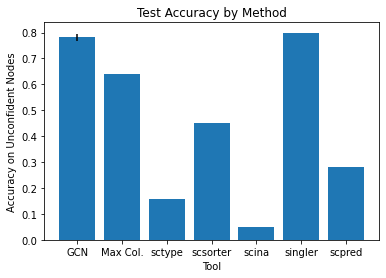

In [30]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots()
ax.bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax.set_xlabel("Tool")
ax.set_ylabel("Accuracy on Unconfident Nodes")
ax.set_title("Test Accuracy by Method")

Text(0.5, 1.0, 'Total Accuracy by Method')

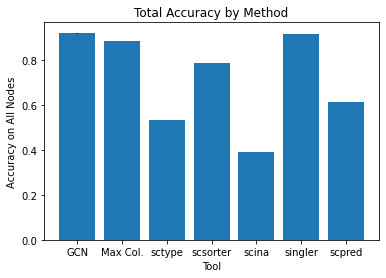

In [31]:
fig, ax = plt.subplots()
ax.bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax.set_xlabel("Tool")
ax.set_ylabel("Accuracy on All Nodes")
ax.set_title("Total Accuracy by Method")

In [6]:
# test putting labels back in
random_inits = 5
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.6_de_rq/", "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq/", "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.8_de_rq/"]
for data_folder in data_folders:
    data_path = data_folder + "query_counts.csv"
    X = pd.read_csv(data_path, index_col=0)
    X, keep_cells = utilities.preprocess(np.array(X), scale=False)
    print(X.shape)
    marker_path = data_folder + "markers.txt"
    _,marker_names = utilities.read_marker_file(marker_path)
    
    meta_path = data_folder + "query_meta.csv"
    metadata = pd.read_csv(meta_path, index_col=0)
    real_y = pd.factorize(metadata['Group'], sort=True)[0]
    real_y = real_y[keep_cells]
    real_y.shape
    
    test_accuracy = [0]*random_inits
    for i in range(random_inits):
        tools = ["sctype","scsorter","scina","singler", "scpred"]
        #tools = ["scsorter","scina","singler"]
        ref_path = data_folder + "ref_counts.csv"
        ref_label_path = data_folder + "ref_labels.csv"
        
        if os.path.exists(data_folder + "preds.csv"):
            all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
            if all_labels.shape[1] != len(tools): 
                all_labels = all_labels[tools]
                #raise Exception("wrong amount of tools in file")
        else:
            all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

        all_labels = all_labels.loc[keep_cells,:]
        all_labels_factored = utilities.factorize_df(all_labels, marker_names)
        encoded_labels = utilities.encode_predictions(all_labels_factored)
        confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
        train_nodes = np.where(confident_labels != -1)[0]
        original_test_nodes = np.where(confident_labels == -1)[0]

        dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

        test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)
        
        m = GCNModel("configs/2_25.txt", 2, dropout=0.0)
        m.train(dataloader, 150, verbose = False)
        
        new_labels, _ = m.predict(test_dataloader)
        new_labels = new_labels.max(dim=1)[1]
        
        #print(len(original_test_nodes))
        for j in range(1,5):
            col_name = "gcn" + str(j)
            all_labels_factored[col_name] = new_labels.cpu()
            encoded_labels = utilities.encode_predictions(all_labels_factored)
            confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
            train_nodes = np.where(confident_labels != -1)[0]
            test_nodes = np.where(confident_labels == -1)[0]

            dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

            test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
            test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

            #print(len(test_nodes))

            #m = GCNModel("configs/2_15.txt", 2, dropout=0.0)
            m.train(dataloader, 50, verbose=False)
            #print(m.validation_metrics(test_dataloader, train_nodes, test_nodes))

            new_labels, _ = m.predict(test_dataloader)
            new_labels = new_labels.max(dim=1)[1]
            
        _,_,_,_,accuracy,_ = m.validation_metrics(test_dataloader, train_nodes, original_test_nodes)
        test_accuracy[i] = accuracy
    print(statistics.mean(test_accuracy))
    print(statistics.stdev(test_accuracy))

(1000, 500)
0.6011204719543457
0.026691604570561273
(999, 500)
0.848888885974884
0.023040499079638933
(999, 500)
0.7612903237342834
0.02885248584038609


In [7]:
# test putting labels back in new model each time
random_inits = 3
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.6_de_rq/", "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq/", "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.8_de_rq/"]
for data_folder in data_folders:
    data_path = data_folder + "query_counts.csv"
    X = pd.read_csv(data_path, index_col=0)
    X, keep_cells = utilities.preprocess(np.array(X), scale=False)
    print(X.shape)
    marker_path = data_folder + "markers.txt"
    _,marker_names = utilities.read_marker_file(marker_path)
    
    meta_path = data_folder + "query_meta.csv"
    metadata = pd.read_csv(meta_path, index_col=0)
    real_y = pd.factorize(metadata['Group'], sort=True)[0]
    real_y = real_y[keep_cells]
    real_y.shape
    
    test_accuracy = [0]*random_inits
    for i in range(random_inits):
        tools = ["sctype","scsorter","scina","singler", "scpred"]
        #tools = ["scsorter","scina","singler"]
        ref_path = data_folder + "ref_counts.csv"
        ref_label_path = data_folder + "ref_labels.csv"
        
        if os.path.exists(data_folder + "preds.csv"):
            all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
            if all_labels.shape[1] != len(tools): 
                all_labels = all_labels[tools]
                #raise Exception("wrong amount of tools in file")
        else:
            all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

        all_labels = all_labels.loc[keep_cells,:]
        all_labels_factored = utilities.factorize_df(all_labels, marker_names)
        encoded_labels = utilities.encode_predictions(all_labels_factored)
        confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
        train_nodes = np.where(confident_labels != -1)[0]
        original_test_nodes = np.where(confident_labels == -1)[0]

        dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

        test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)
        
        m = GCNModel("configs/2_25.txt", 2, dropout=0.0)
        m.train(dataloader, 150, verbose = False)
        
        new_labels, _ = m.predict(test_dataloader)
        new_labels = new_labels.max(dim=1)[1]
        
        #print(len(original_test_nodes))
        for j in range(1,5):
            col_name = "gcn" + str(j)
            all_labels_factored[col_name] = new_labels.cpu()
            encoded_labels = utilities.encode_predictions(all_labels_factored)
            confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = 3)
            train_nodes = np.where(confident_labels != -1)[0]
            test_nodes = np.where(confident_labels == -1)[0]

            dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

            test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
            test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

            #print(len(test_nodes))

            m = GCNModel("configs/2_25.txt", 2, dropout=0.0)
            m.train(dataloader, 150, verbose=False)
            #print(m.validation_metrics(test_dataloader, train_nodes, test_nodes))

            new_labels, _ = m.predict(test_dataloader)
            new_labels = new_labels.max(dim=1)[1]
            
        _,_,_,_,accuracy,_ = m.validation_metrics(test_dataloader, train_nodes, original_test_nodes)
        test_accuracy[i] = accuracy
    print(statistics.mean(test_accuracy))
    print(statistics.stdev(test_accuracy))

(1000, 500)
0.6302521228790283
0.014005601406097412
(999, 500)
0.8814814885457357
0.03394500312454106
(999, 500)
0.8387096722920736
0.08534682520664126
